In [2]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [3]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, Statistics, Plots

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [8]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [16]:
species_to_exclude_cis = ["cis-2-heptene", "(z)-1,1,1,4,4,4-hexafluorobut-2-ene", "cis-1,2-dichloroethylene",
"cis-4-octene", "(1r,2s,5r)-(-)-2-isopropyl-5-methyl-cyclohexanol", "cis-3-methyl-2-pentene", 
"cis-1,2-dimethylcyclohexane", "crotonaldehyde", ".beta.-pinene", "tricyclo[5.2.1.0(2,6)]decane",
"cis-4,4-dimethyl-2-pentene", "cis-1,2-dimethylcyclopentane", "cis-2-octene", "2-pentene", "cis-1,3-dimethyl cyclohexane",
"cis-octahydro-1h-indene", "cis-1,3-dimethylcyclopentane", "cis-1,3-dichloropropene", "cis-3-heptene",
"cis-2-decene", "d-(+)-limonene", "limonene", "cis-2,2-dimethyl-3-hexene", "cis-1,3-pentadiene", 
"(z)-1,3,3,3-tetrafluoroprop-1-ene", ".alpha.-pinene", "d-.alpha.-pinene", "cis-1,4-dimethyl cyclohexane",
"cis-decahydronaphthalene", "decalin", "cis-3-methylcyclohexanol"]

species_to_exclude_trans = ["trans-2-heptene", "(e)-1,1,1,4,4,4-hexafluorobut-2-ene", "trans-1,2-dichloroethene",
"trans-4-octene", "dl-(1r,2s,5r)-rel-5-methyl-2-(1-methylethyl)cyclohexanol", "trans-3-methyl-2-pentene", 
"trans-1,2-dimethylcyclohexane", "trans-crotonaldehyde", "(-)-beta-pinene", "exo-tricyclo[5.2.1.0(2,6)]decane",
"trans-4,4-dimethyl-2-pentene", "trans-1,2-dimethylcyclopentane", "trans-2-octene", "trans-2-pentene",
"trans-1,3-dimethyl cyclohexane", "trans-octahydro-1h-indene", "trans-1,3-dimethylcyclopentane",
"trans-1,3-dichloropropene", "trans-3-heptene", "trans-2-decene", "l-(-)-limonene", "trans-2,2-dimethyl-3-hexene",
"trans-1,3-pentadiene", "(e)-1,3,3,3-tetrafluoroprop-1-ene", "l-.alpha.-pinene", "trans-1,4-dimethylcyclohexane",
"trans-decahydronaphthalene", "trans-3-methylcyclohexanol"]

# append!(species_to_exclude_cis,species_to_exclude_trans)

pcp_source_params_isomers_removed = filter(row -> !(row.species in species_to_exclude_cis), pcp_source_params);


In [17]:
chemical_family = "All Species"

if lowercase(chemical_family) == "linear alkanes"
    contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
    processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params_isomers_removed) 
    processed_data = sort(processed_data_lin_alkanes, :Mw)
else
    if lowercase(chemical_family) == "all species"
        processed_data = pcp_source_params_isomers_removed
    else
        processed_data = filter(row -> lowercase(row.family) == lowercase(chemical_family), pcp_source_params_isomers_removed) 
        processed_data = sort(processed_data, :Mw)
    end
end

processed_data.isomeric_SMILES;
# println(processed_data);

In [18]:
isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints = []

for i in isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)

    fp_str1 = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str2 = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))


    fp_str = fp_str1 * fp_str2
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

println(length(fingerprints[1]))

4096


In [19]:
# Remove repeated columns
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

println(length(fingerprints[1]))

3102


In [20]:
function count_repeated_vectors(arr)
    vector_counts = Dict{Vector, Int}()

    for vector in arr
        if haskey(vector_counts, vector)
            vector_counts[vector] += 1
        else
            vector_counts[vector] = 1
        end
    end

    repeated_vectors = filter(kv -> kv[2] > 1, vector_counts)
    return repeated_vectors
end

function compare_fingerprints(vectors::Vector{Vector{T}}) where T
    n = length(vectors)
    total_differences = 0
    differences = []
    counts = Dict{Int, Int}()

    for i in 1:n
        for j in i+1:n
            # Count the number of differing elements
            diff_count = sum(vectors[i] .!= vectors[j])
            counts[diff_count] = get(counts, diff_count, 0) + 1
            total_differences += sum(vectors[i] .!= vectors[j])
            push!(differences, sum(vectors[i] .!= vectors[j]))
        end
    end
    average_diff = total_differences / (n * (n - 1) / 2)  # n choose 2
    std_diff = std(differences)
    return counts, average_diff,std_diff
end;

function find_interval_indices(value, intervals)
    for (i, interval) in enumerate(intervals[1:end-1])
        if value >= interval && value < intervals[i+1]
            return i
        end
    end
    return length(intervals) - 1
end;

In [21]:
# Fingerprint comparisons for a given chemical family
repeated_vectors = count_repeated_vectors(fingerprints)
number_repeated_strings = length(values(repeated_vectors))

for i in keys(repeated_vectors)
    # Use a list comprehension to find indices where the vector matches the target_key
    matching_indices = findall(vector -> vector == i, fingerprints)
    for i in  matching_indices
        println(processed_data[i,:species])
    end
end

result_compare = compare_fingerprints(fingerprints)

(Dict(719 => 98, 699 => 138, 831 => 11, 319 => 982, 687 => 133, 185 => 5783, 823 => 6, 420 => 280, 525 => 213, 365 => 533…), 165.1183016146647, 114.93270288168233)

number_repeated_strings = 0
mean_bits_in_common_between_pairs = 165.1183016146647
std_dev_bits_in_common_between_pairs = 114.93270288168233


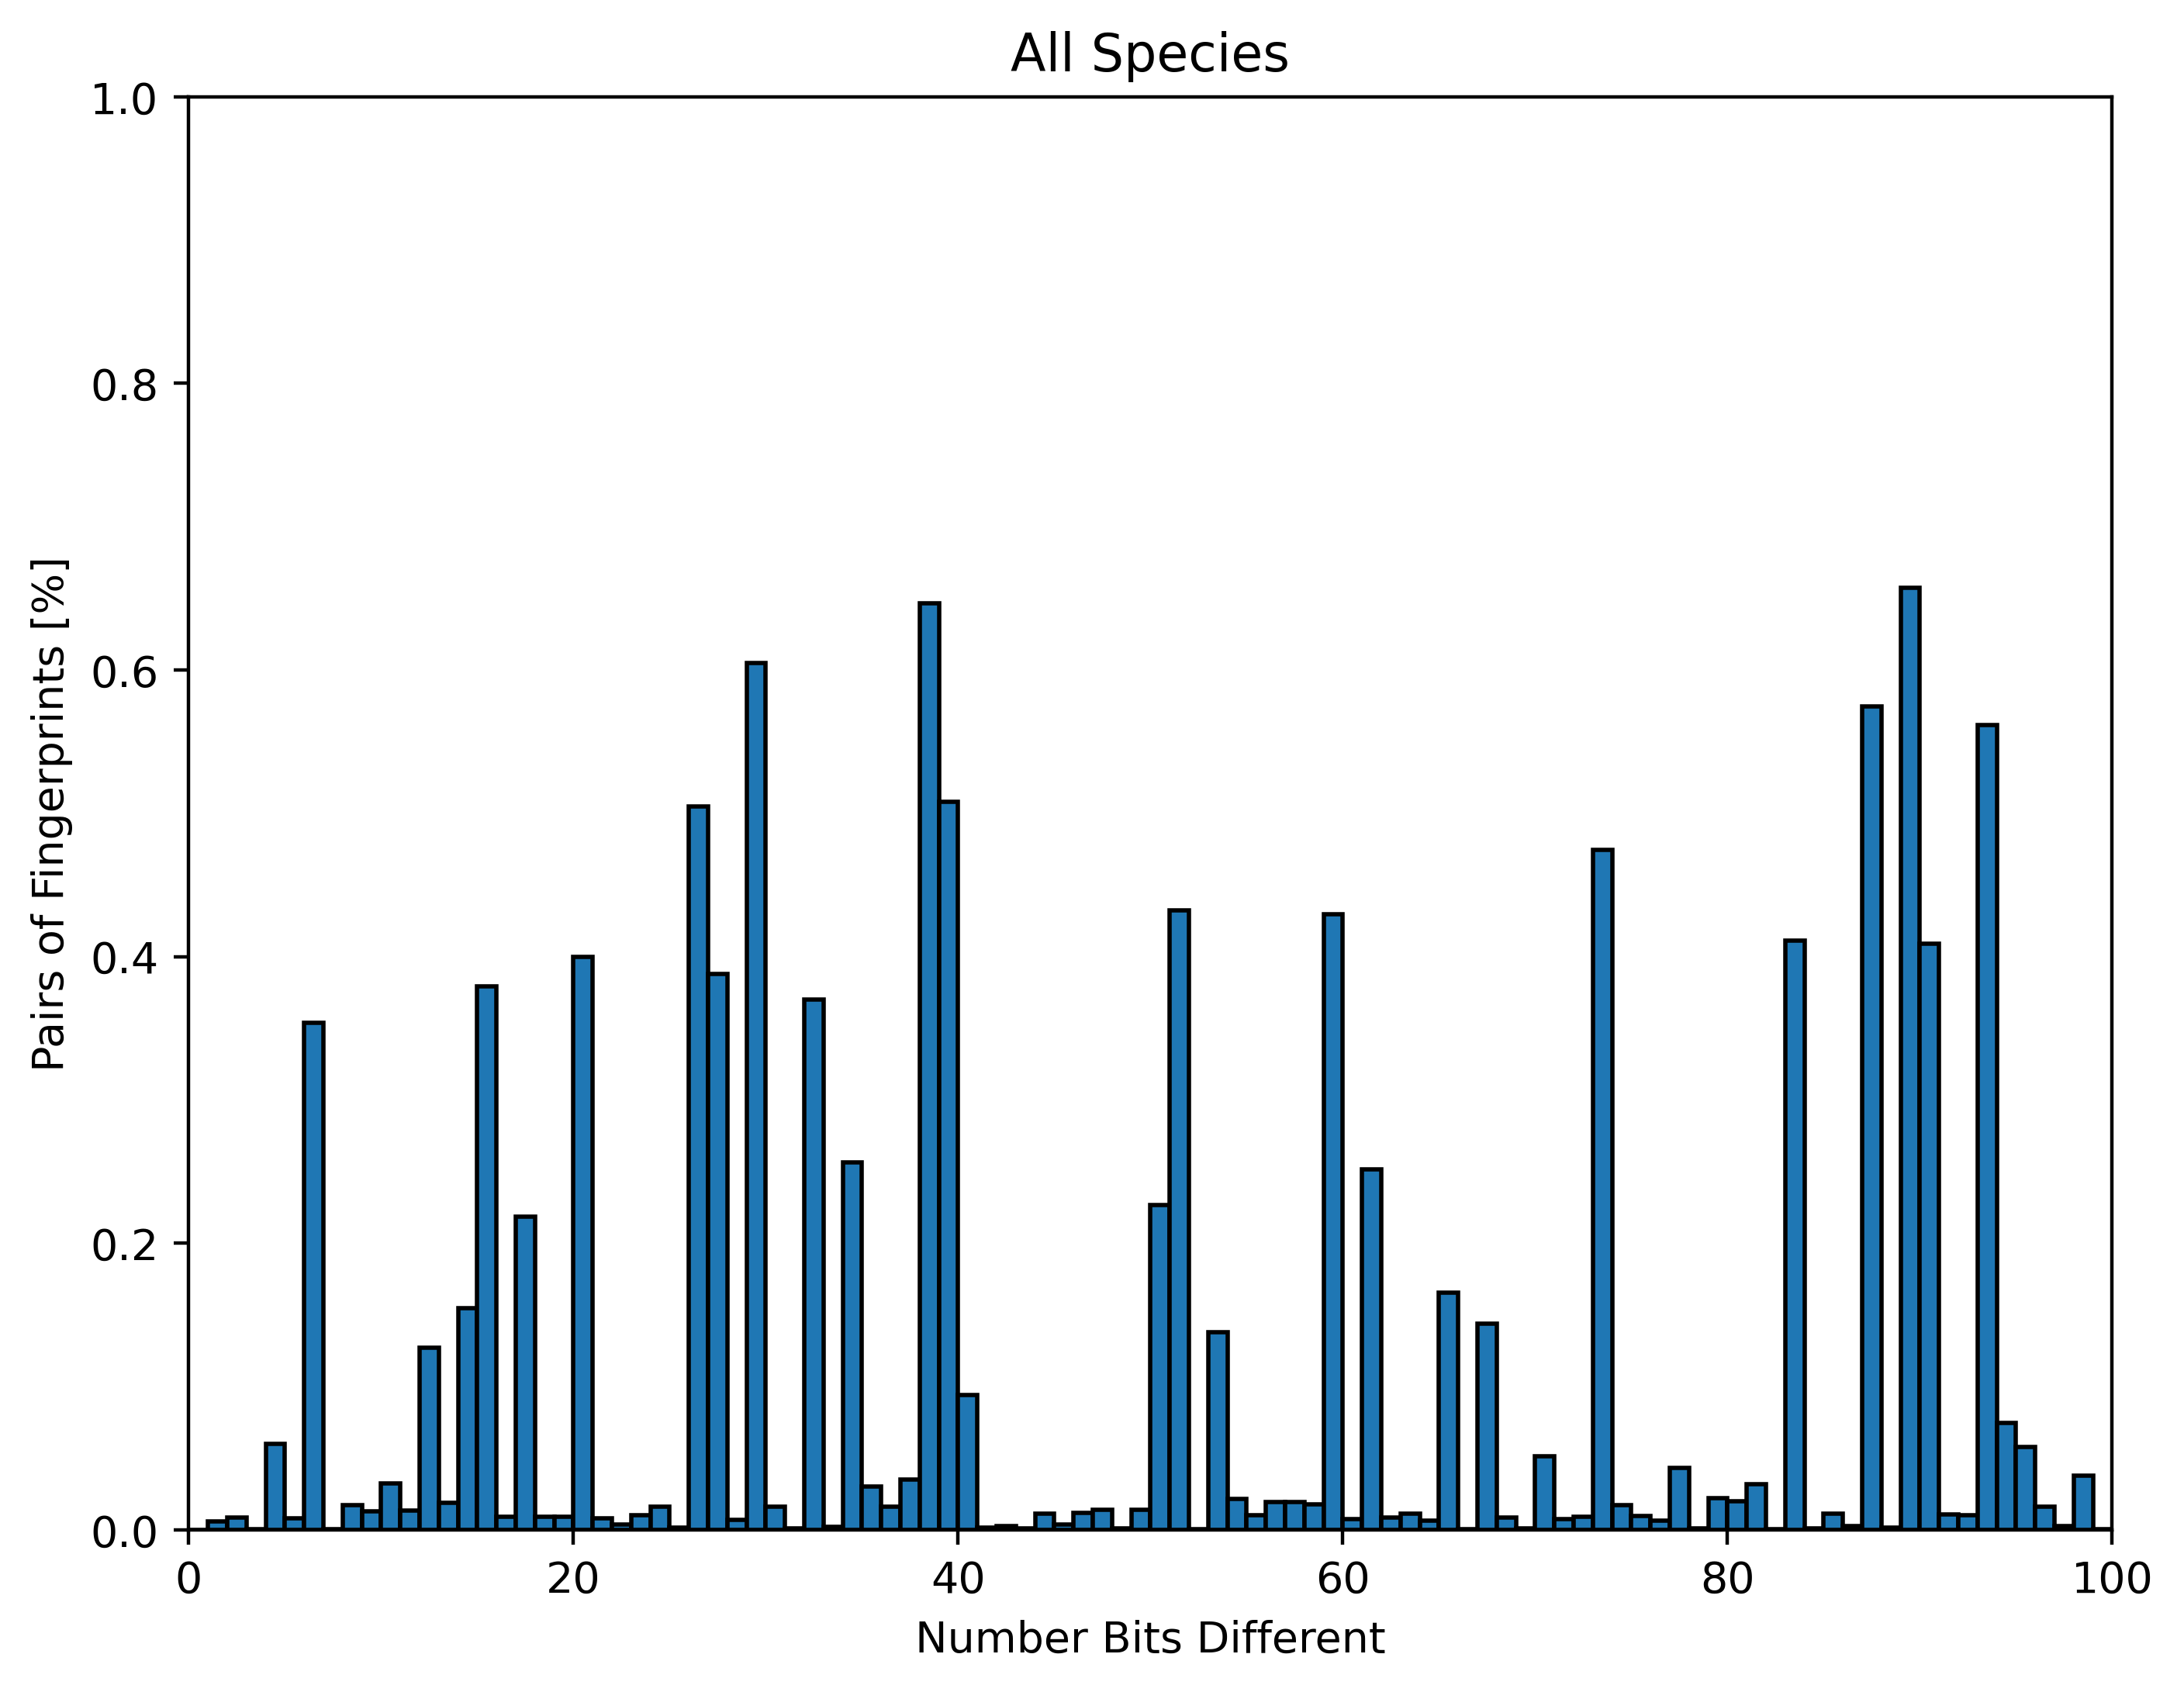

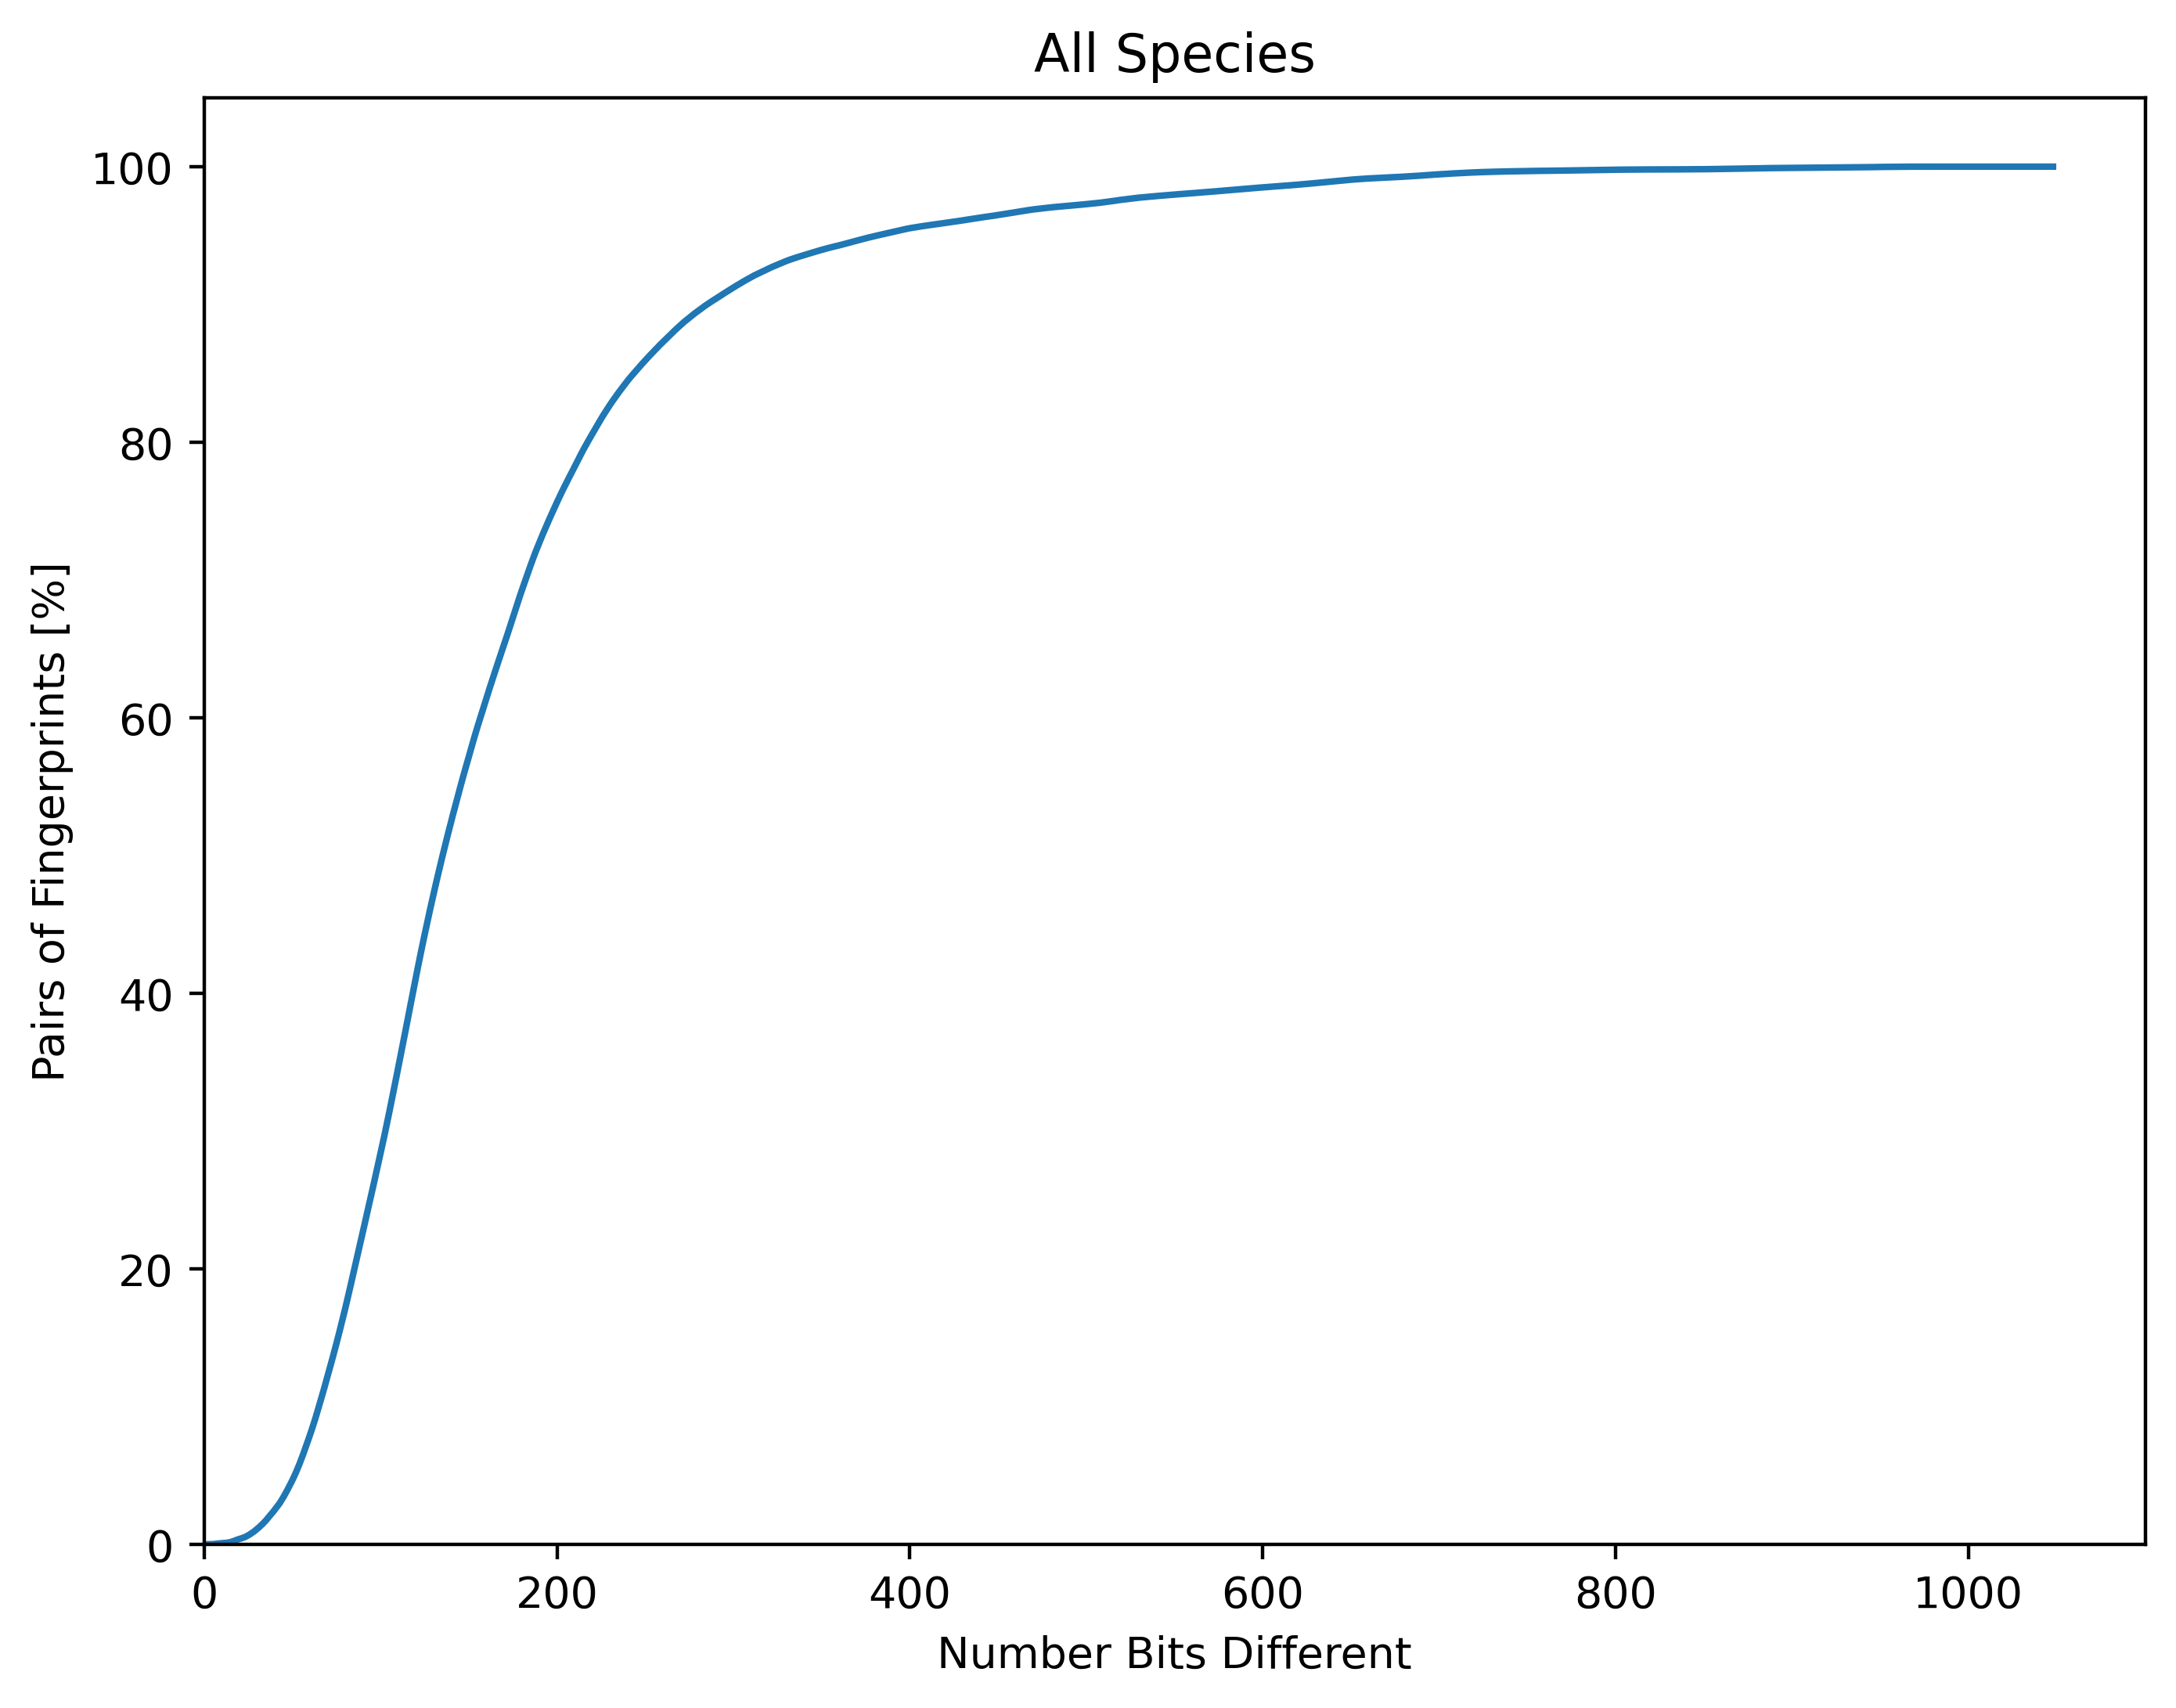

In [22]:
n_pairs = collect(values(result_compare[1]))
total_count = sum(values(result_compare[1]))
proportion_pairs = n_pairs ./total_count

n_bits_different = collect(keys(result_compare[1]))
n_bits_different_sorted = sort(collect(keys(result_compare[1])))

cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

mean_bits_in_common_between_pairs = result_compare[2]
std_dev_bits_in_common_between_pairs = result_compare[3]

@show number_repeated_strings
@show mean_bits_in_common_between_pairs
@show std_dev_bits_in_common_between_pairs

# Calculate intervals of 10 for number of bits different
n_bits_interval = 1
n_bits_intervals = 0:n_bits_interval:maximum(n_bits_different_sorted) + n_bits_interval

# Group the data into intervals
interval_indices = [find_interval_indices(v, n_bits_intervals) for v in n_bits_different_sorted]

# Calculate aggregated values for each interval
aggregated_proportion_pairs = [sum(proportion_pairs[interval_indices .== i]) for i in 1:length(n_bits_intervals)-1]
interval_centers = (n_bits_intervals[1:end-1] + n_bits_intervals[2:end]) / 2

# Bar Chart
plt.figure(figsize=(8, 6), dpi=400)
plt.bar(interval_centers, aggregated_proportion_pairs * 100, width=n_bits_interval, edgecolor="black")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 1])
plt.xlim([0, 100])

# ECDF
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(n_bits_different_sorted, cumulative_probabilities * 100, label="ECDF")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 105])
plt.xlim([0, nothing]);


In [23]:
# This plots the CFDs for mutliple fingerprints

n_bits_different_sorted_all_fp = []
cumulative_percentiles_all_fp = []
number_repeated_strings_all_fp = []
mean_bits_in_common_between_pairs_all_fp = []
std_dev_bits_in_common_between_pairs_all_fp = []

isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints_rdkit = []
fingerprints_morgan = []
fingerprints_pattern = []
fingerprints_atom_pair = []
fingerprints_combine1 = []

for i in isomeric_smiles
    
    mol = get_mol(i)

    fingerprint_spec_i_rdkit = []
    fingerprint_spec_i_morgan = []
    fingerprint_spec_i_pattern = []
    fingerprint_spec_i_atom_pair = []
    fingerprint_spec_i_combine1 = []

    fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))

    fp_str_spec_i_combined1 = fp_str_spec_i_pattern * fp_str_spec_i_atom_pair
    
    append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
    append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
    append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
    append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])
    append!(fingerprint_spec_i_combine1, [parse(Float64, string(c)) for c in fp_str_spec_i_combined1])

    # desc = get_descriptors(mol)
    # relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]
    # relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)

    append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
    append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
    append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
    append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
    append!(fingerprints_combine1, [fingerprint_spec_i_combine1])

end

all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_pattern, fingerprints_atom_pair, fingerprints_combine1]

for fingerprints in all_fingerprints
# Remove repeated columns
    for num = [0, 1]
        num_cols = length(fingerprints[1])
        zero_cols = trues(num_cols)
        for vec in fingerprints
            zero_cols .&= (vec .== num)
        end
        keep_cols = .!zero_cols # Create a Mask
        fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
    end

    # Fingerprint comparisons for a given chemical family
    repeated_vectors = count_repeated_vectors(fingerprints)
    number_repeated_strings = length(values(repeated_vectors))

    for i in keys(repeated_vectors)
        # Use a list comprehension to find indices where the vector matches the target_key
        matching_indices = findall(vector -> vector == i, fingerprints)
        for i in  matching_indices
            println(processed_data[i,:species]) # comment this in to print the names of repeated species
        end
    end

    result_compare = compare_fingerprints(fingerprints)

    n_pairs = collect(values(result_compare[1]))
    total_count = sum(values(result_compare[1]))
    proportion_pairs = n_pairs ./total_count

    n_bits_different = collect(keys(result_compare[1]))
    n_bits_different_sorted = sort(collect(keys(result_compare[1])))

    cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

    mean_bits_in_common_between_pairs = result_compare[2]
    std_dev_bits_in_common_between_pairs = result_compare[3]

    push!(number_repeated_strings_all_fp, number_repeated_strings)
    push!(mean_bits_in_common_between_pairs_all_fp, mean_bits_in_common_between_pairs)
    push!(std_dev_bits_in_common_between_pairs_all_fp, std_dev_bits_in_common_between_pairs)

    push!(n_bits_different_sorted_all_fp,n_bits_different_sorted)
    push!(cumulative_percentiles_all_fp,cumulative_probabilities*100)
    # ECDF

    @show number_repeated_strings
    
end

1,3-dimethyl adamantane
1-ethyltricyclo(3.3.1.1(3,7))decane
1,3,5-trimethyladamantane
diethylene glycol monobutyl ether
diethylene glycol dibutyl ether
propane
tripropylaluminum
methyl oleate
methyl erucate
tripropylene glycol
tetrapropylene glycol
2-octanone
2-nonanone
2-undecanone
trimethylene glycol dimethyl ether
tetramethylene glycoldimethyl ether
octanenitrile
1,6-dicyanohexane
nonanenitrile
decanoic acid butyl ester
dodecanoic acid butyl ester
decanedioic acid dibutyl ester
cyclooctanone
3-nonanone
cycloundecanone
cyclododecanone
caprylic acid
nonanoic acid
capric acid
undecanoic acid
lauric acid
tridecanoic acid
myristic acid
pentadecanoic acid
palmitic acid
margarinic acid
stearic acid
nonadecanoic acid
arachidic acid
octylmercaptan
nonylmercaptan
1-decanethiol
n-dodecyl mercaptan
isopropyl tert-butyl ether
di-tert-butyl ether
diethylene glycol monomethyl ether
diethylene glycol dimethyl ether
methane
ammonia
water
hydrogen fluoride
silane
hydrogen sulfide
phosphorous trihydri

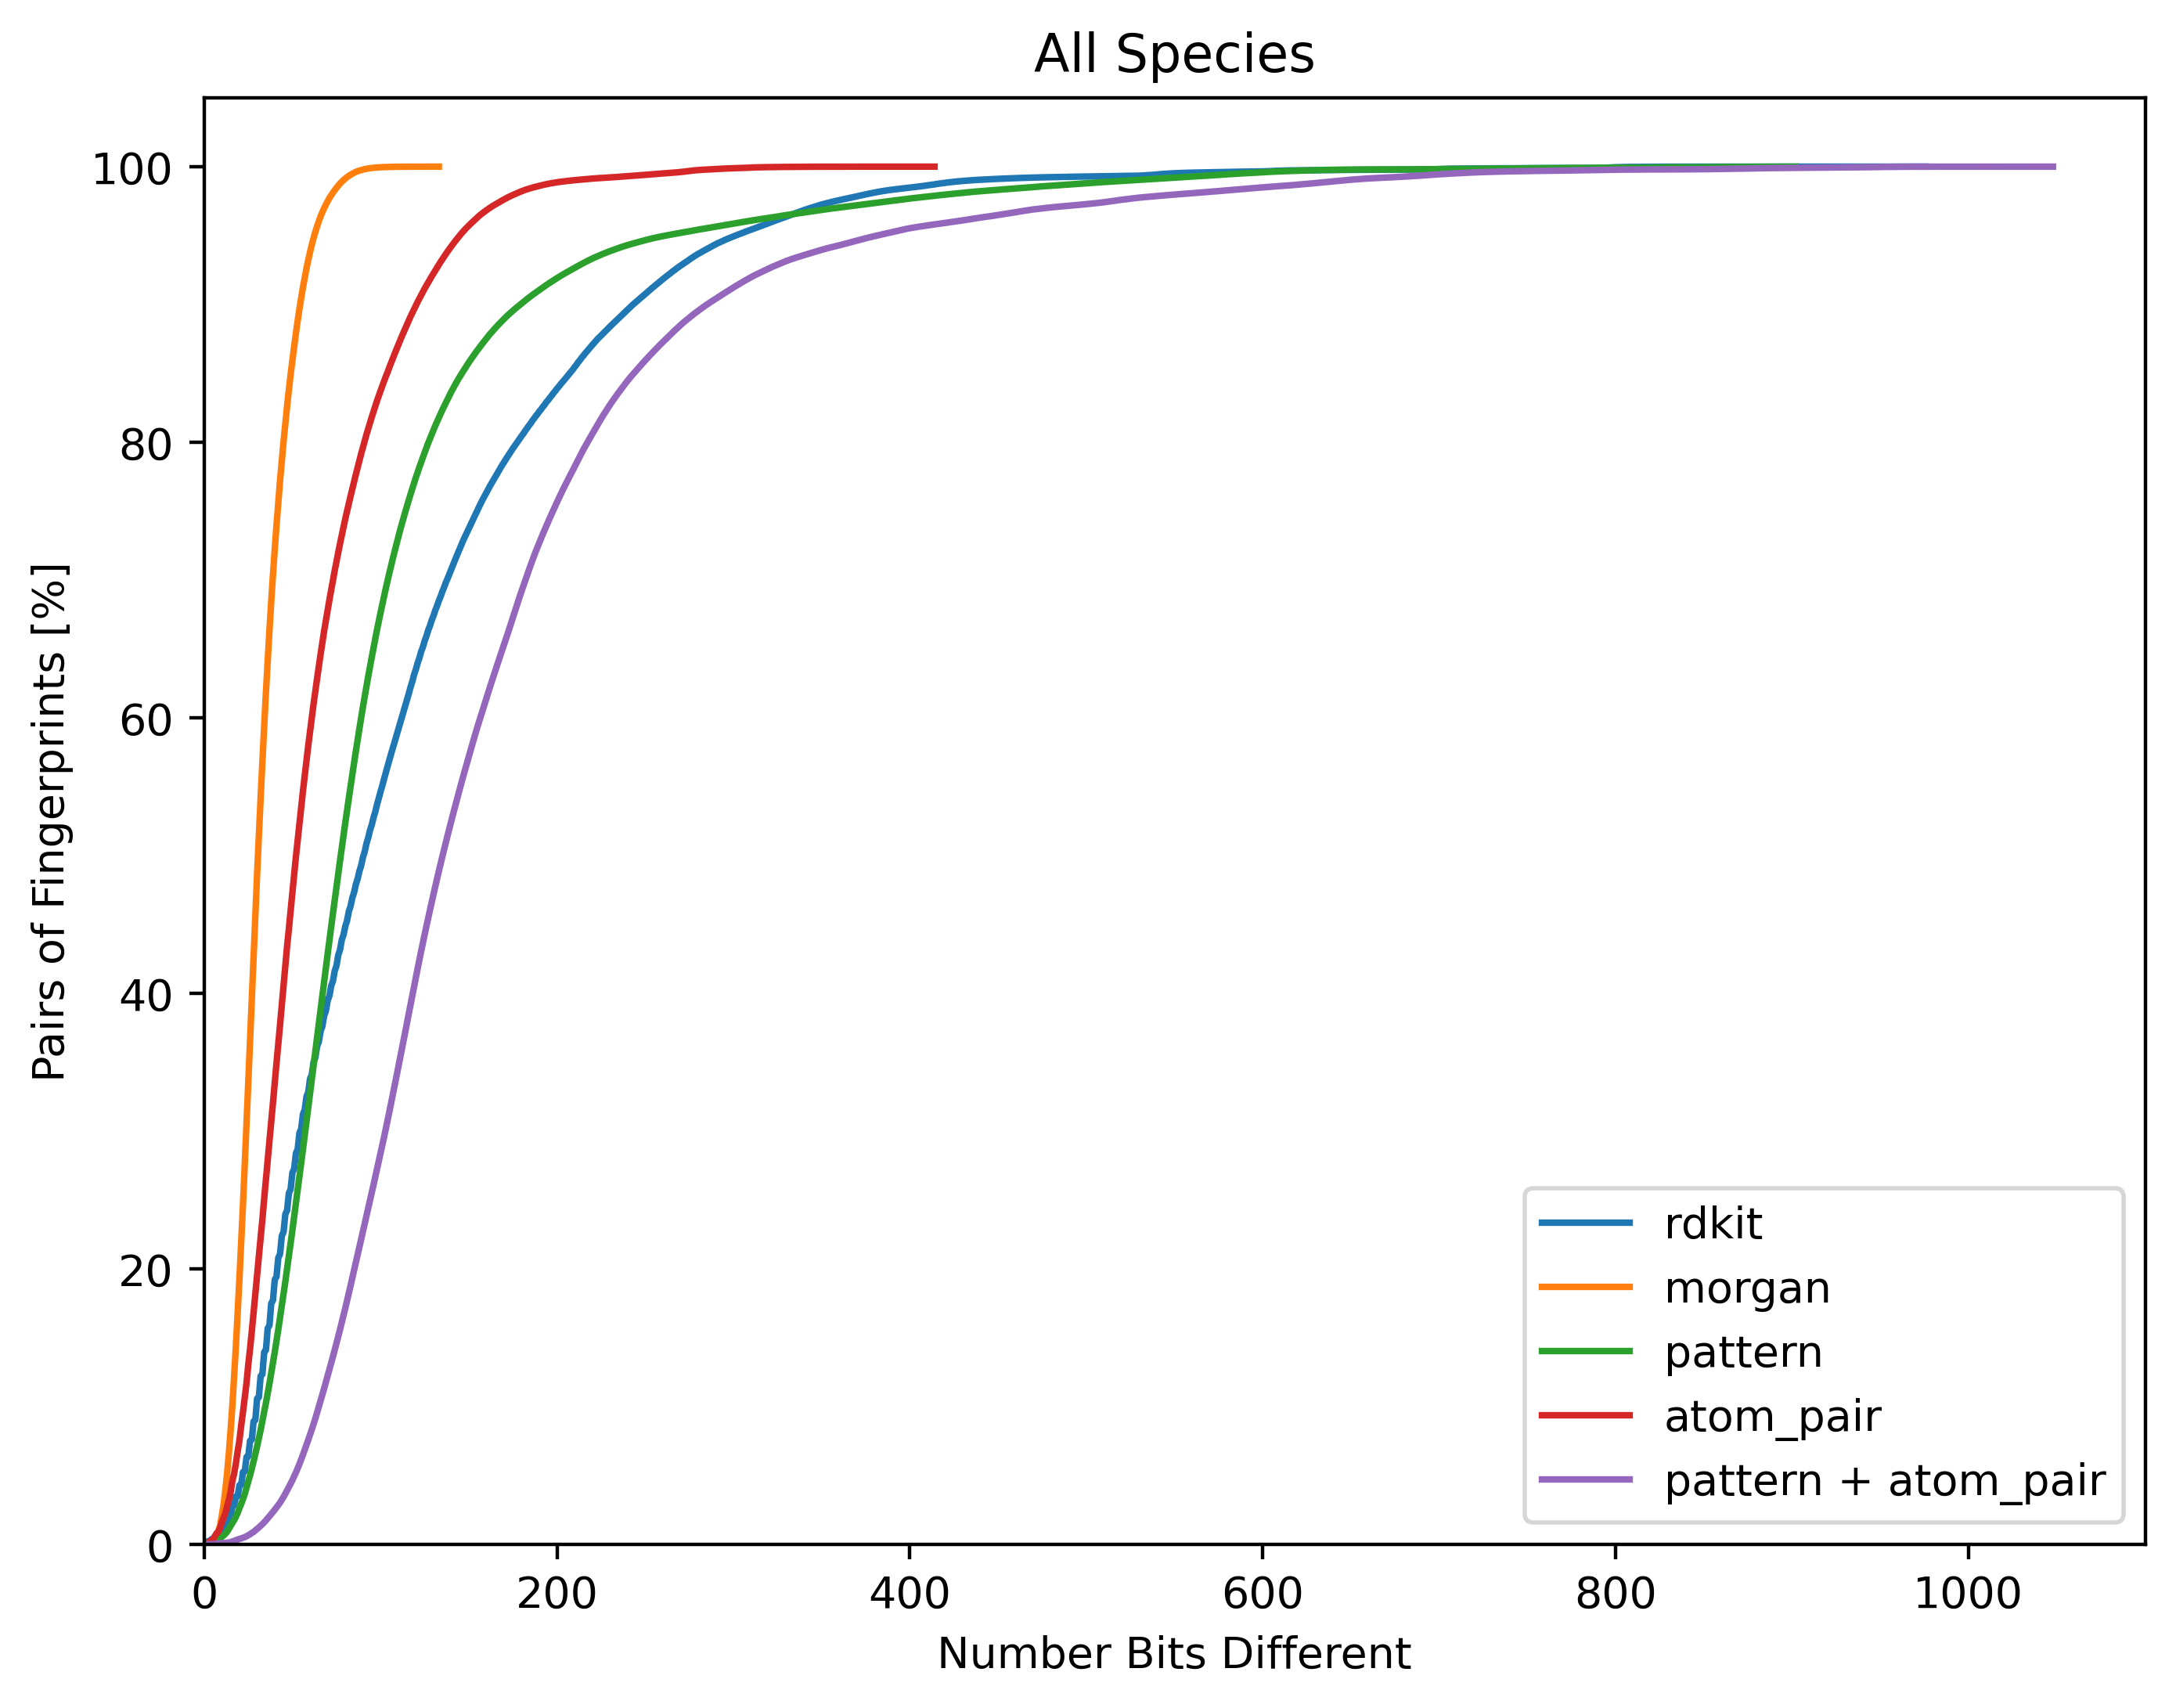

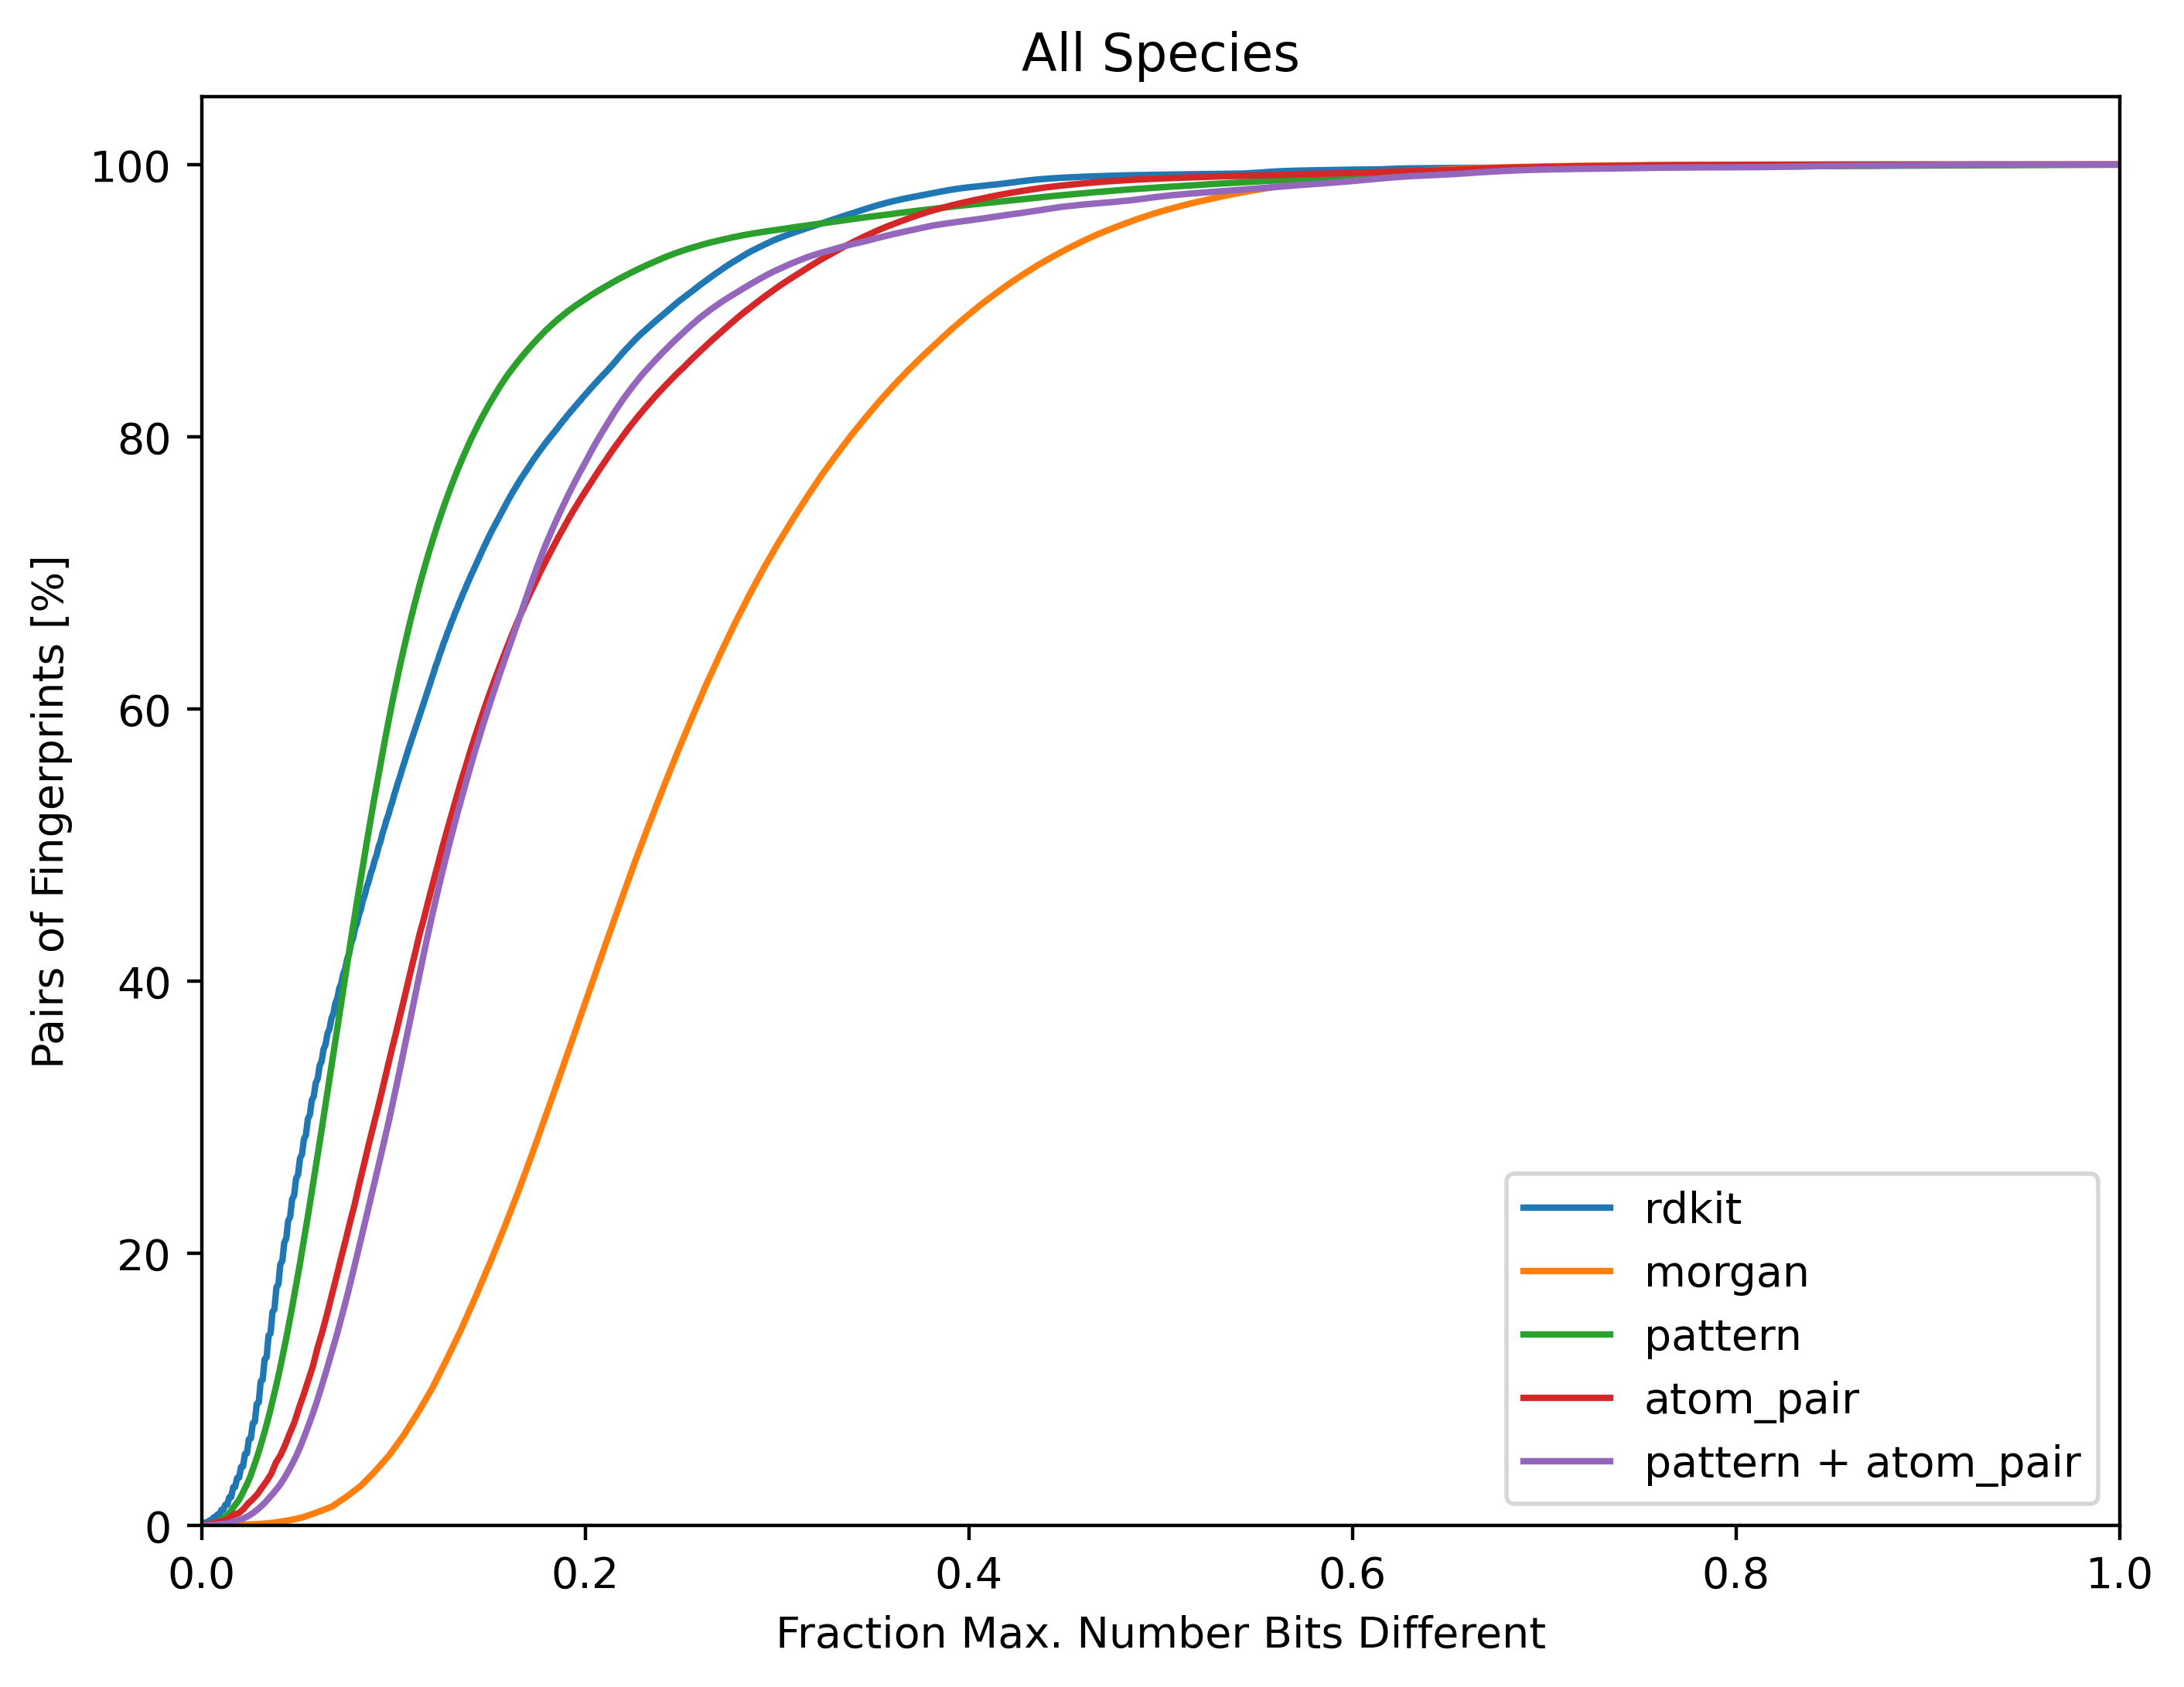

In [24]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "lower right")
plt.ylim([0, 105])
plt.xlim([0, nothing]);

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i] ./n_bits_different_sorted_all_fp[i][end], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Fraction Max. Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "lower right")

plt.ylim([0, 105])
plt.xlim([0, 1]);

In [25]:
unique_values = unique(processed_data[!, :family])
means_all = []
std_devs_all = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_combine1 = []

    means_per_family = []
    std_devs_per_family = []

    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_combine1 = []

        mol = get_mol(i)
        # desc = get_descriptors(mol)
        # relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        # relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    
        fp_str_spec_i_combined1 = fp_str_spec_i_pattern * fp_str_spec_i_atom_pair
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])
        append!(fingerprint_spec_i_combine1, [parse(Float64, string(c)) for c in fp_str_spec_i_combined1])    

        # append!(fingerprint_spec_i_rdkit, relevant_desc)
        # append!(fingerprint_spec_i_morgan, relevant_desc)
        # append!(fingerprint_spec_i_atom_pair, relevant_desc)
        # append!(fingerprint_spec_i_pattern, relevant_desc)
        # append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_combine1, [fingerprint_spec_i_combine1])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_combine1]

    for fingerprints in all_fingerprints
        # Remove repeated columns
            for num = [0, 1]
                num_cols = length(fingerprints[1])
                zero_cols = trues(num_cols)
                for vec in fingerprints
                    zero_cols .&= (vec .== num)
                end
                keep_cols = .!zero_cols # Create a Mask
                fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
            end
        
            # Fingerprint comparisons for a given chemical family
            repeated_vectors = count_repeated_vectors(fingerprints)
            number_repeated_strings = length(values(repeated_vectors))
        
            for i in keys(repeated_vectors)
                # Use a list comprehension to find indices where the vector matches the target_key
                matching_indices = findall(vector -> vector == i, fingerprints)
                for i in  matching_indices
                    # println(processed_data[i,:species]) # comment this in to print the names of repeated species
                end
            end

            result_compare = compare_fingerprints(fingerprints)        
            mean_bits_in_common_between_pairs = result_compare[2]
            std_dev_bits_in_common_between_pairs = result_compare[3]

            push!(means_per_family, mean_bits_in_common_between_pairs)
            push!(std_devs_per_family, std_dev_bits_in_common_between_pairs)

    end

    push!(means_all, means_per_family)
    push!(std_devs_all,std_devs_per_family)

    @show means_per_family
    @show std_devs_per_family

end

Alkanes
means_per_family = Any[16.977848101265824, 20.901582278481012, 52.506012658227846, 50.0370253164557, 102.54303797468354]
std_devs_per_family = Any[8.322071200252553, 9.991107031646932, 41.192150379071116, 33.40567017187583, 69.60692819640414]
Inorganic compounds
means_per_family = Any[10.120507399577168, 6.8276955602537, 5.69661733615222, 33.29492600422833, 38.99154334038055]
std_devs_per_family = Any[8.496140559004283, 2.5825860416981277, 4.443642289771438, 34.08040159929339, 37.037974683031365]
Other compounds
means_per_family = Any[157.8376904795191, 41.66816306030622, 80.5921731881469, 125.69328590438614, 206.28545909253305]
std_devs_per_family = Any[122.44762941510325, 16.49888887776518, 43.42439071475035, 113.21523021361305, 135.09674262442596]
Alkynes
means_per_family = Any[12.93939393939394, 14.545454545454545, 17.62121212121212, 13.606060606060606, 31.227272727272727]
std_devs_per_family = Any[6.786590370562293, 5.716862555853296, 8.240173918095794, 8.758079852568295, 

In [26]:
unique_values = unique(processed_data[!, :family])
means_restructure = [[means_all[i][j] for i = 1:length(means_all)] for j = 1:length(means_all[1])];
std_devs_restructure = [[std_devs_all[i][j] for i = 1:length(std_devs_all)] for j = 1:length(std_devs_all[1])];

println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [27]:
idx = sortperm(means_restructure[5], rev=true)
sorted_means_restructure = deepcopy(means_restructure)

for i in 1:length(sorted_means_restructure)
    sorted_means_restructure[i] = means_restructure[i][idx]
end

sorted_names = unique_values[idx]

println(sorted_means_restructure[5])
println(sorted_names)

[214.38292682926829, 212.11102040816326, 206.28545909253305, 140.55841584158415, 135.94037267080745, 128.2724399494311, 112.05681818181819, 111.60504504504505, 102.54303797468354, 97.6923076923077, 97.35135135135135, 95.99629972247918, 81.4153627311522, 79.93187708256201, 74.01025290498974, 71.7030303030303, 63.497835497835496, 56.748538011695906, 55.539313399778514, 44.857142857142854, 38.99154334038055, 31.227272727272727, 6.166666666666667]
String31["Fluorides", "Silanes/siloxanes", "Other compounds", "Polyfunctional compounds", "Aromatic hydrocarbons", "Esters", "Acids", "Cyclic compounds", "Alkanes", "Halogenated compounds", "Sulfides/thiophenes", "Ethers", "Ketones", "Alcohols", "Amines", "Alkenes", "Aldehydes", "Thiols", "Chlorides", "Nitriles", "Inorganic compounds", "Alkynes", "Elements"]


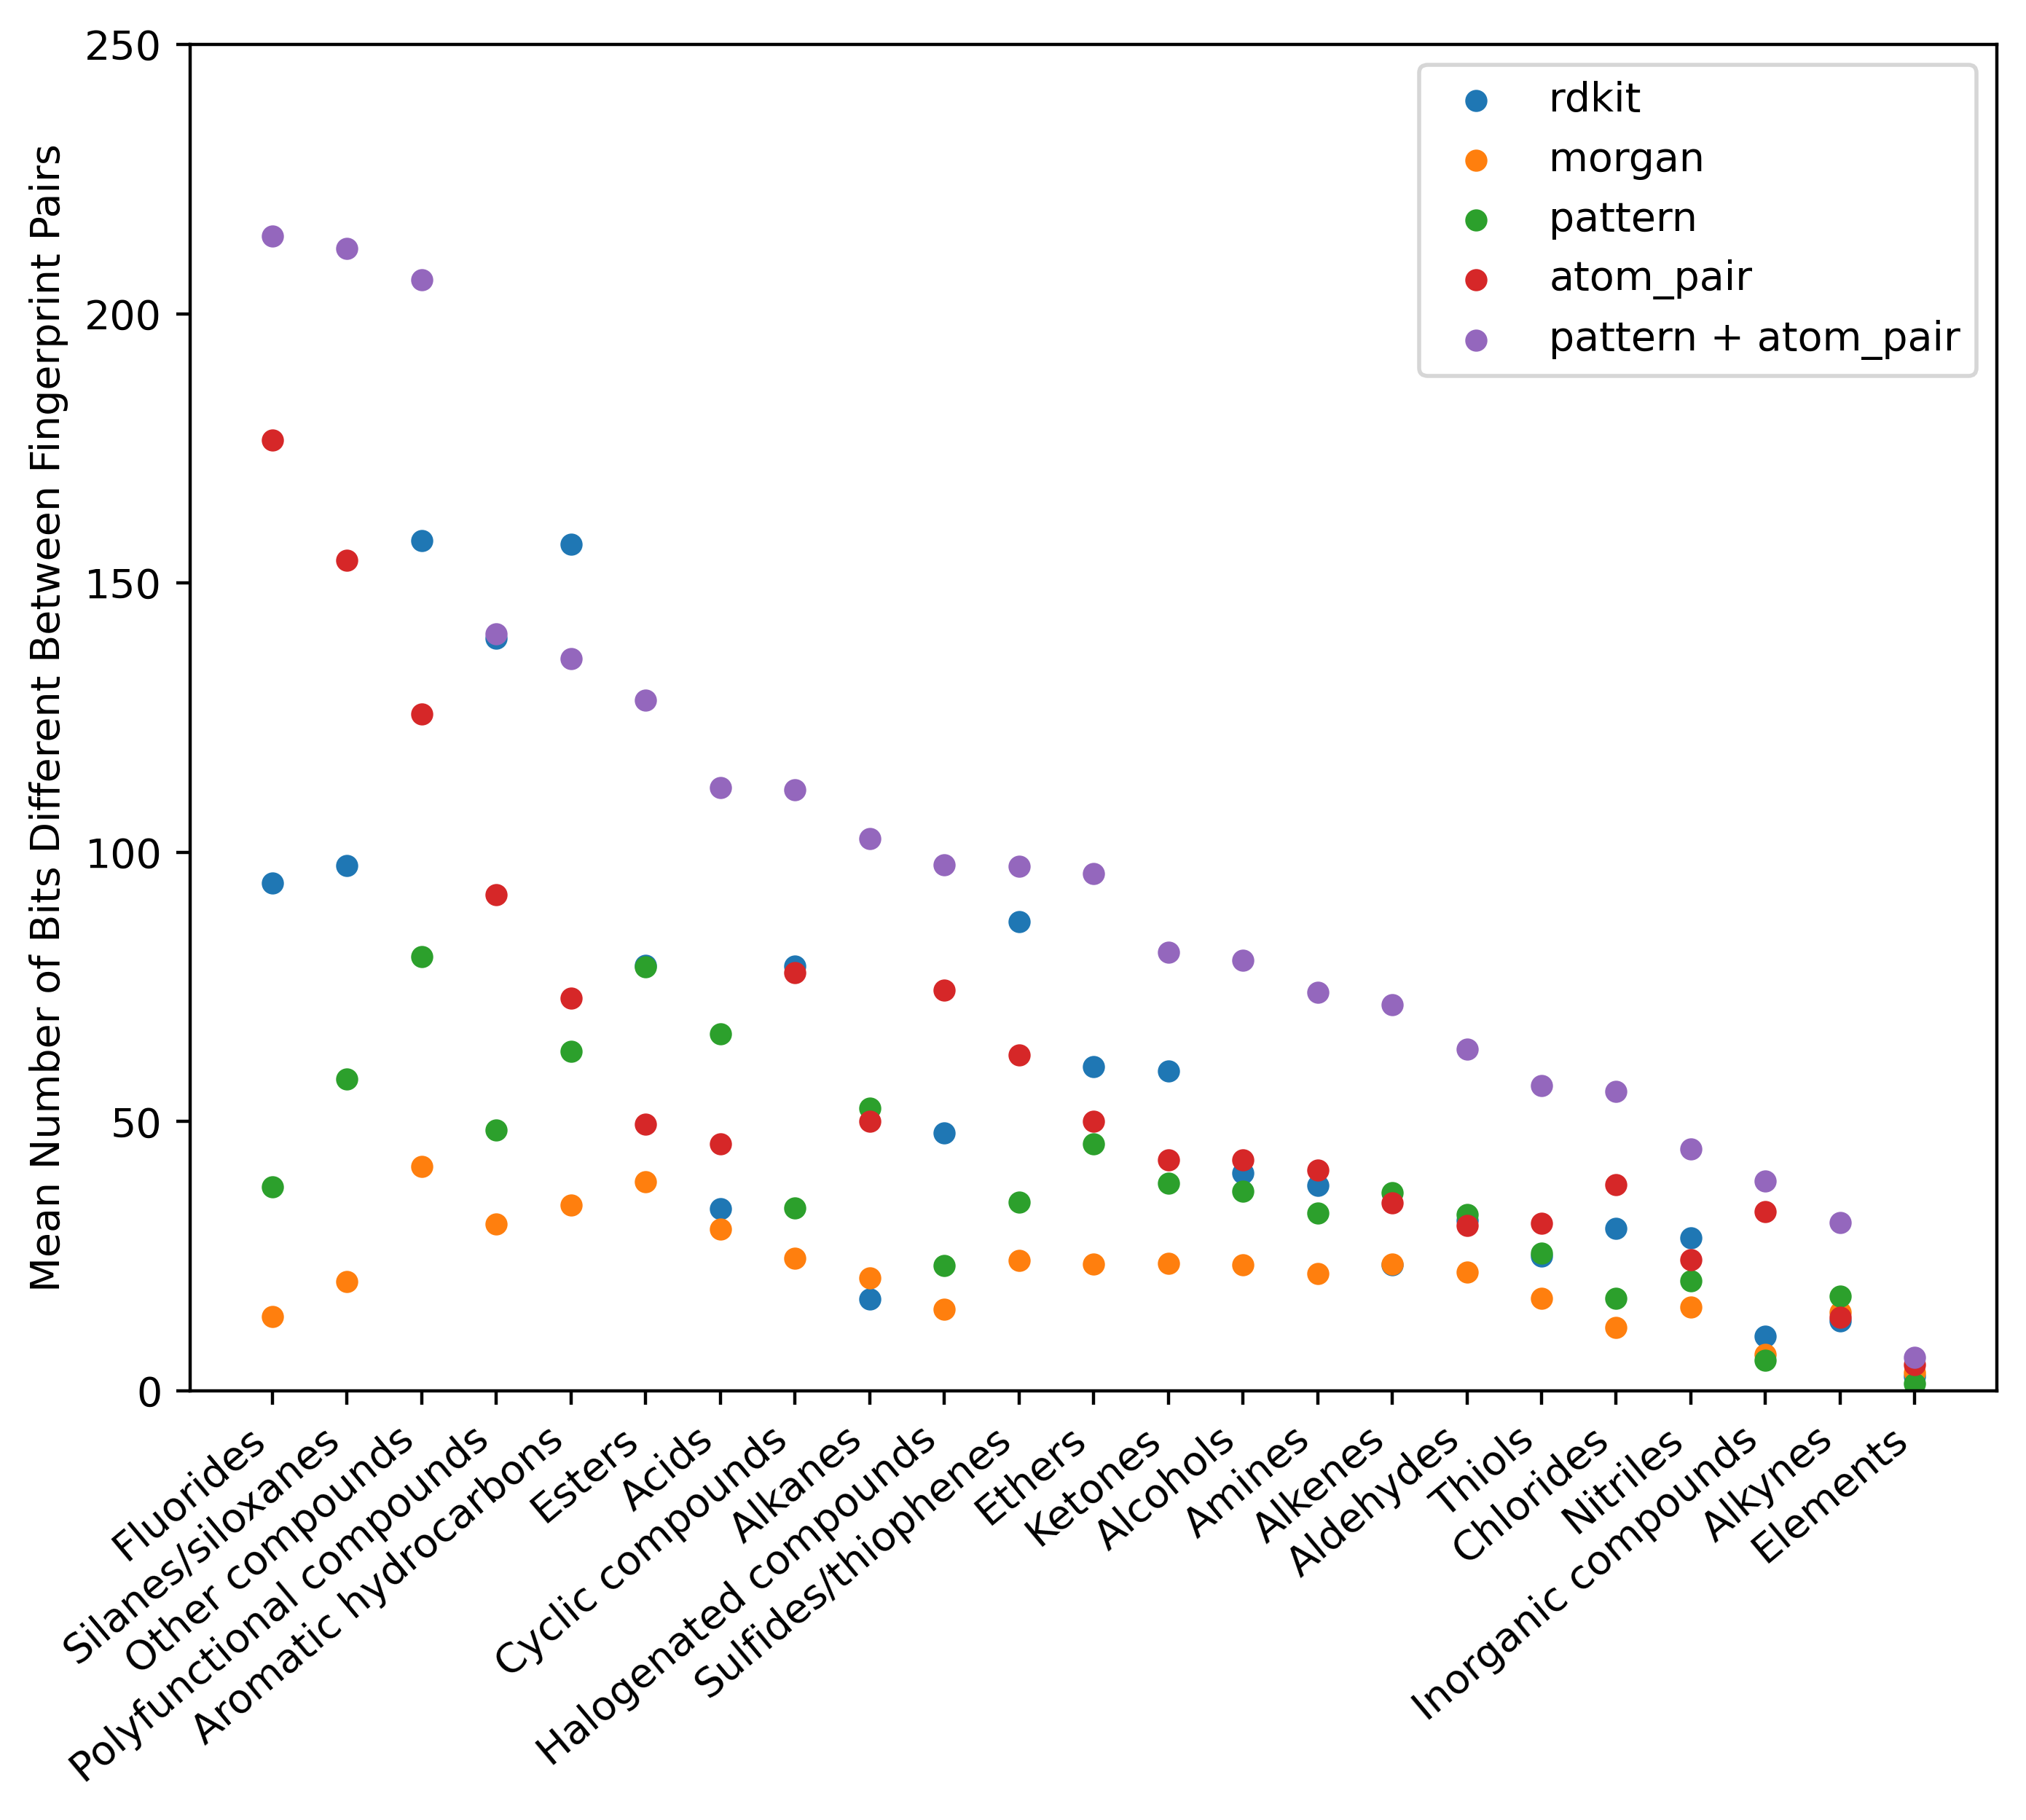

(0.0, 250.0)

In [29]:
default_colours = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"] #, "#8c564b", "#e377c2",  "#7f7f7f", "#bcbd22", "#17becf"]

plt.figure(figsize=(8, 6), dpi=400)
for i = 1:length(means_all[1])
    plt.scatter(sorted_names,sorted_means_restructure[i],color = default_colours[i],s=20)
end

plt.ylabel("Mean Number of Bits Different Between Fingerprint Pairs")
plt.xticks(rotation=40,ha="right")
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "upper right")
plt.ylim([0,250])

In [ ]:
minima = []
fingerprints_all_families = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_total = []


    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_total = []

        mol = get_mol(i)
        desc = get_descriptors(mol)
        relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 1024))
        # fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 1024))
        fp_str_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 7, "nbits" => 1024))

        fp_str_rdkit_total = fp_str_rdkit  * fp_str_atom_pair * fp_str_pattern
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_morgan])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_atom_pair])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_pattern])
        append!(fingerprint_spec_i_total, [parse(Float64, string(c)) for c in fp_str_rdkit_total])

        append!(fingerprint_spec_i_rdkit, relevant_desc)
        append!(fingerprint_spec_i_morgan, relevant_desc)
        append!(fingerprint_spec_i_atom_pair, relevant_desc)
        append!(fingerprint_spec_i_pattern, relevant_desc)
        append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_total, [fingerprint_spec_i_total])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_total]

    for i in 1:length(all_fingerprints)

        fingerprints = all_fingerprints[i]

        for num = [0, 1]
            num_cols = length(fingerprints[1])
            zero_cols = trues(num_cols)
            for vec in fingerprints
                zero_cols .&= (vec .== num)
            end
            keep_cols = .!zero_cols # Create a Mask
            all_fingerprints[i] = [vec[keep_cols] for vec in fingerprints] # Apply Mask
        end
    end

    minima_per_fingerprint = []

    for i in 1:length(all_fingerprints)
        fingerprints = all_fingerprints[i]

        num_diff_for_adjacent_spec_in_fam = []

        for molecule = 1:length(fingerprints)-1
            num_different = 0
            # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
            for i = 1:length(fingerprints[1])
                if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
                    num_different += 1
                end
            end
            push!(num_diff_for_adjacent_spec_in_fam, num_different)
        end
        println(count(i->(i == 0), num_diff_for_adjacent_spec_in_fam)) 
        push!(minima_per_fingerprint, minimum(num_diff_for_adjacent_spec_in_fam))
    end

    push!(fingerprints_all_families,all_fingerprints)
    push!(minima, minima_per_fingerprint)
end